In [ ]:
# Using text embeddings as Features

# This script demonstrates how to use text embeddings as features in a supervised non-parametric prediction problem.
# This framework could also apply to any discrete or continuous prediction problem as long as labelled data is
# availible.

import os
import json
import gzip
import pandas as pd
import langchain
from urllib.request import urlopen


In [ ]:
# First, we import the data. Here we will be using a sample of amazon reviews.

!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz

!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_AMAZON_FASHION.json.gz


--2023-08-22 08:18:39--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93185167 (89M) [application/x-gzip]
Saving to: ‘AMAZON_FASHION.json.gz’

AMAZON_FASHION.json 100%[===================>]  88.87M  34.3MB/s    in 2.6s    

2023-08-22 08:18:42 (34.3 MB/s) - ‘AMAZON_FASHION.json.gz’ saved [93185167/93185167]

--2023-08-22 08:18:42--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_AMAZON_FASHION.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33023658 (31M) [application/x-gzip]
Saving to: ‘meta_AMAZON_FASHION.json.gz’



In [ ]:
# Extract data from files
data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

metadata = []
with gzip.open('meta_AMAZON_FASHION.json.gz') as f:
    for l in f:
        metadata.append(json.loads(l.strip()))


In [ ]:
# Load the data to dataframes

df = pd.DataFrame.from_dict(data)
df = df[df['reviewText'].notna()]

df_meta=pd.DataFrame.from_dict(metadata)


In [ ]:
# Truncate the reviewText

max_text_length=400
def truncate_review(text):
    return text[:max_text_length]

df['truncated']=df.apply(lambda row: truncate_review(row['reviewText']),axis=1)

# Look for productIds with enough reviews

df.groupby('asin').count().sort_values('overall')


,overall,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,truncated
asin,,,,,,,,,,,,
0764443682,1,1,1,1,1,1,1,1,0,0,0,1
B019YM0O28,1,1,1,1,1,1,1,1,0,0,0,1
B019YME2N0,1,1,1,1,1,1,1,1,0,0,0,1
B019YMNS08,1,1,1,1,1,1,1,1,0,0,0,1
B00S7N99AY,1,1,1,1,1,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
B000PHANNM,2566,2566,2566,2566,2566,2566,2563,2566,85,2563,112,2566
B00RLSCLJM,3633,3633,3633,3633,3633,3633,3632,3633,225,3538,210,3633
B00I0VHS10,3884,3884,3884,3884,3884,3884,3880,3884,128,3872,107,3884


In [ ]:
# Work on only a slice of the dataframe

df = df.loc[df['asin'] == 'B000KPIHQ4'].copy()

# Looking at the data we can see that relationship between the review text and the vote is often unintuitive!

review_text = df['reviewText'].iloc[0]
vote = df['vote'].iloc[0]

print("Review Text:")
print(review_text)
print("")
print("Vote:")
print(vote)


Review Text:
Good price, good product. Howver, it is generic and if you really need orthotics, best to have them individually fitted. These are a good value.

Vote:
2


In [ ]:
# Import and apply embeddings from HuggingFace
# Warning! Be careful when/if applying embeddings from OpenAI like this - the full review dataframe is more than 800k rows.
# Took about 15 minutes to run for me!

from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()

df['embeddings']=df.apply(lambda row: embeddings.embed_query(row['truncated']),axis=1)


In [ ]:
# Prepare training and test sets for training Random Forest Regressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    list(df.embeddings.values),
    df.overall,
    test_size = 0.2,
    random_state=1
)


In [ ]:
# Train

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=150)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


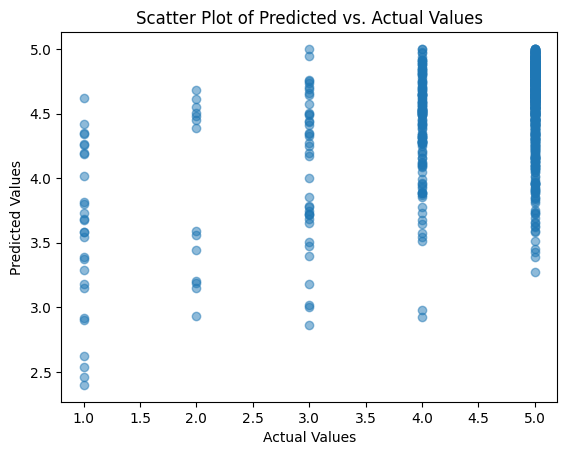

Mean Absolute Error (MAE): 0.5329119812455142
Root Mean Squared Error (RMSE): 0.7719050515315832
R2 Score: 0.26933928734837154


In [ ]:
'''
To evaluate the performance of the model and visualise the results, we can consider a few metrics:

Mean Absolute Error (MAE): It measures the average absolute difference between the predicted and actual values. Lower MAE indicates better performance.

Root Mean Squared Error (RMSE): RMSE is another commonly used metric that calculates the square root of the average squared difference between the predicted and actual values. It penalizes larger errors more than MAE and can be useful to understand the magnitude of errors.

R2 Score: The R2 score, also known as the coefficient of determination, represents the proportion of the variance in the dependent variable that can be explained by the independent variables. It ranges from 0 to 1, where 1 indicates a perfect fit. Higher R2 scores indicate better model performance.
'''

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Scatter plot of predicted vs. actual values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs. Actual Values')
plt.show()

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)

# Even with an out of the box Random Forest Regression model, evaluation metrics show that the predictions are only 0.5 away from the
# actual review scores on average.


In [ ]:
# The problem is really a multinomial classification one, if we round the predicted values we can get some more interpretable
# statistics.

from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

# Round the predicted values
y_pred_rounded = np.round(y_pred).astype(int)

# Calculate precision, accuracy, recall, and F1 score
precision = precision_score(y_test, y_pred_rounded, average='weighted', zero_division=0)
accuracy = accuracy_score(y_test, y_pred_rounded)
recall = recall_score(y_test, y_pred_rounded, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_rounded, average='weighted', zero_division=0)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_rounded)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred_rounded, zero_division=0)

# Print the evaluation metrics
print("Evaluation Metrics:")
print("--------------------")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print the confusion matrix
print("\nConfusion Matrix:")
print("-----------------")
print(confusion_mat)

# Print the classification report
print("\nClassification Report:")
print("----------------------")
print(classification_rep)


Evaluation Metrics:
--------------------
Precision: 0.6837
Accuracy: 0.6320
Recall: 0.6320
F1 Score: 0.6480

Confusion Matrix:
-----------------
[[  0   2   9  16   1]
 [  0   0   5   5   4]
 [  0   0   6  23  11]
 [  0   0   2  64  70]
 [  0   0   4 170 483]]

Classification Report:
----------------------
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        28
         2.0       0.00      0.00      0.00        14
         3.0       0.23      0.15      0.18        40
         4.0       0.23      0.47      0.31       136
         5.0       0.85      0.74      0.79       657

    accuracy                           0.63       875
   macro avg       0.26      0.27      0.26       875
weighted avg       0.68      0.63      0.65       875



In [ ]:
'''
Evaluation Metrics:
The precision metric measures the ability of the model to correctly predict the positive class. A precision value of 0.6941 indicates that, on average, 69.41% of the predicted positive class labels are correct.

The accuracy metric represents the overall correctness of the predictions. An accuracy of 0.6411 means that the model correctly classified 64.11% of the instances.

The recall metric calculates the ratio of true positives to the sum of true positives and false negatives. In this case, a recall of 0.6411 suggests that the model identified 64.11% of the positive class instances.

The F1 score is the harmonic mean of precision and recall. It provides a balanced measure of the model's performance. With an F1 score of 0.6565, the model achieves a reasonable balance between precision and recall.

Confusion Matrix:
The confusion matrix shows the counts of the predicted labels against the actual labels. Each row corresponds to the actual classes, while each column corresponds to the predicted classes. For example, the value 11 in the first row and third column indicates that there were 11 instances of class 3 (actual) that were predicted as class 4 (predicted).

Classification Report:
The classification report provides a detailed summary of the model's performance for each class. It includes precision, recall, and F1 score for each class, as well as support (the number of instances in each class). For instance, the precision for class 1 (1.0) indicates that the model correctly predicted class 1 for 0% of the instances. The weighted average considers the class imbalance and provides an overall performance measure for the model.

Overall, the evaluation metrics, confusion matrix, and classification report give insights into the model's performance in classifying the reviews into their respective scores. However, it's important to note that the model's performance varies across different classes, with better performance for class 5 and lower performance for other classes.
'''


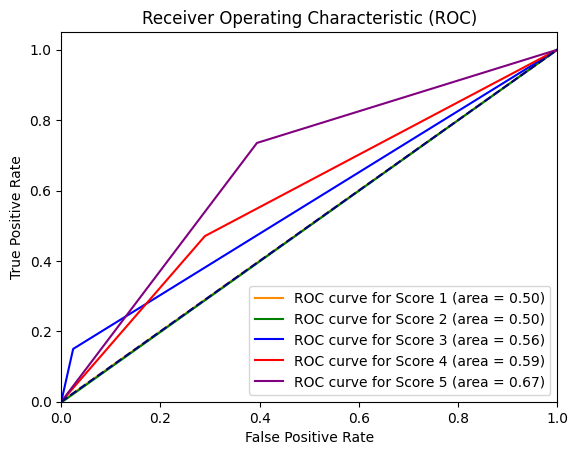

In [ ]:
# We can evaluate how good the model is at prediction using a ROC curve

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert y_test and y_pred_rounded to binary format
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred_rounded, classes=[1, 2, 3, 4, 5])

# Calculate ROC curve for each class
n_classes = 5  # Update this according to the number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except ValueError:
        # Handle the case where there is only one class present
        fpr[i], tpr[i] = [0, 1], [0, 1]
        roc_auc[i] = 0.5  # Set AUC to 0.5 for single-class scenario

# Plot ROC curves for each class
plt.figure()
colors = ['darkorange', 'green', 'blue', 'red', 'purple']  # Add more colors if needed
labels = ['Score 1', 'Score 2', 'Score 3', 'Score 4', 'Score 5']  # Add labels for each class
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve for %s (area = %0.2f)' % (labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


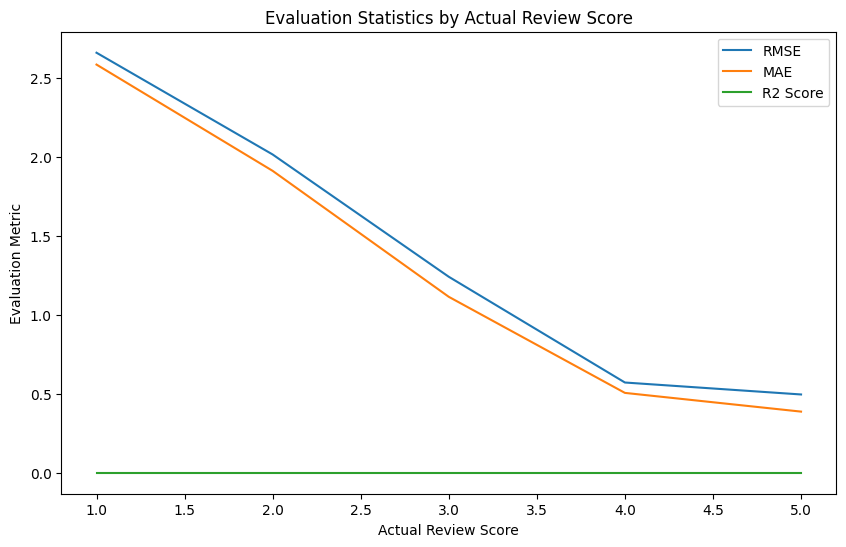


Evaluation Statistics for Actual Review Score 1:
RMSE: 2.657440357158303
MAE: 2.5824189342403625
R2 Score: 0.0

Evaluation Statistics for Actual Review Score 2:
RMSE: 2.0135769325983213
MAE: 1.91
R2 Score: 0.0

Evaluation Statistics for Actual Review Score 3:
RMSE: 1.2398629285363127
MAE: 1.1130097222222222
R2 Score: 0.0

Evaluation Statistics for Actual Review Score 4:
RMSE: 0.5707722894395589
MAE: 0.5051049015271323
R2 Score: 0.0

Evaluation Statistics for Actual Review Score 5:
RMSE: 0.4951246701774165
MAE: 0.38665996641478834
R2 Score: 0.0


In [ ]:
# Or by using conditional continuous evaluation metrics

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function to calculate evaluation statistics for each actual review score
def evaluate_by_score(y_test, y_pred, score):
    mask = (y_test == score)
    y_test_score = y_test[mask]
    y_pred_score = y_pred[mask]

    # Calculate RMSE for the given score
    rmse = np.sqrt(mean_squared_error(y_test_score, y_pred_score))

    # Calculate MAE for the given score
    mae = mean_absolute_error(y_test_score, y_pred_score)

    # Calculate R2 score for the given score
    r2 = r2_score(y_test_score, y_pred_score)

    return rmse, mae, r2

# List to store evaluation statistics for each score
scores = [1, 2, 3, 4, 5]
rmse_scores = []
mae_scores = []
r2_scores = []

# Calculate evaluation statistics for each score
for score in scores:
    rmse, mae, r2 = evaluate_by_score(y_test, y_pred, score)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Plot evaluation statistics by actual review score
plt.figure(figsize=(10, 6))
plt.plot(scores, rmse_scores, label='RMSE')
plt.plot(scores, mae_scores, label='MAE')
plt.plot(scores, r2_scores, label='R2 Score')
plt.xlabel('Actual Review Score')
plt.ylabel('Evaluation Metric')
plt.title('Evaluation Statistics by Actual Review Score')
plt.legend()
plt.show()

# Print evaluation statistics for each score
for i, score in enumerate(scores):
    print(f"\nEvaluation Statistics for Actual Review Score {score}:")
    print("RMSE:", rmse_scores[i])
    print("MAE:", mae_scores[i])
    print("R2 Score:", r2_scores[i])

# Either way, this shows that the current model is much better at predicting products that are review highly, compared to products that
# get bad reviews.

# This could be a symptom of the language used in positive reviews, with certain words and phrases being highly indicative of a 5*
# review, whereas negative language used in 1-3 reviews carries less clear signal.
